# Secondary Eclipse of Tylos (WASP-121 b)

### Import `lightkurve`, `astropy`, and retrieve relevant data

In [179]:
import lightkurve as lk
import numpy as np
from matplotlib import pyplot as plt
import astropy as ap
import astropy.units as u
##Find and download all data for WASP-121 from the QLP pipeline
data = lk.search_lightcurve("WASP-121", author="QLP").download_all()

### Detrend, Normalize, and remove NANs

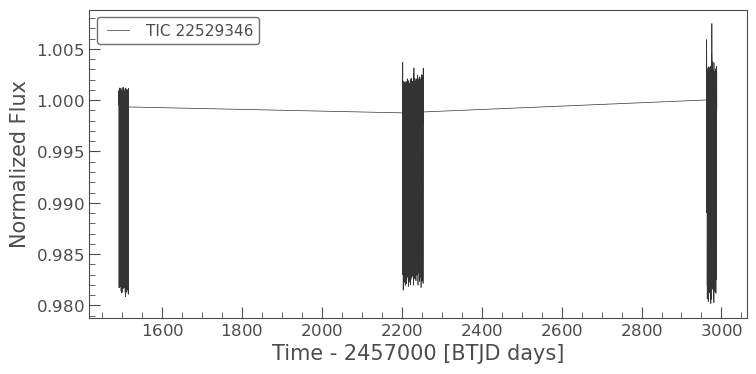

In [196]:
##Normalize and remove outliers from each lightcurve. 
##It is important to normalize each lightcurve individually before appending, as median flux can change from visit-to-visit
for index, light_curves in enumerate(data):
    ##The flatten method normalizes in addition to detrending. To only normalize, use the .normalize() method.
    data[index] = data[index].flatten()
    data[index] = data[index].remove_outliers()
    
#Now stitch them together
lc = data.stitch()
##Show the plot to ensure we have the right data
lc.plot()
plt.show()

### Use Box-Least Squares (BLS) to Determine Period, Epochs, and Transit Depth

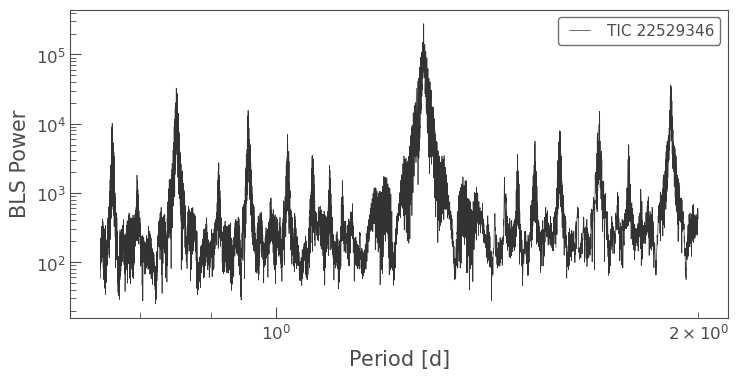

{'transit_times': <Time object: scale='tdb' format='btjd' value=[1491.99452424 1493.26945527 1494.5443863  ... 2984.93875877 2986.2136898
 2987.48862083]>, 'per_transit_count': array([ 5,  5,  4, ..., 43, 43, 44]), 'per_transit_log_likelihood': array([3123.26835703, 2888.69590124, 2806.1693645 , ..., 4403.06489627,
       4520.79570564, 4237.47721085]), 'depth': (<Quantity 0.01546329>, <Quantity 2.15680922e-05>), 'depth_phased': (<Quantity 0.00021445>, <Quantity 2.16032574e-05>), 'depth_half': (<Quantity 0.00783146>, <Quantity 1.59262435e-05>), 'depth_odd': (<Quantity 0.01586237>, <Quantity 3.02845224e-05>), 'depth_even': (<Quantity 0.0150846>, <Quantity 2.95325029e-05>), 'harmonic_amplitude': <Quantity 0.00245467>, 'harmonic_delta_log_likelihood': -212106.80060151627}
The best period is: 1.2749310286339386 d
The best depth is: 0.015463290377490587
The transit epoch is: 1491.994524238323
The duration is: 0.1 d


In [201]:
##We can generate a BLS model by using LightKurves built in methods
##Frequency_factor is a parameter that informs how fine of a period
##grid the BLS should sample over, at the cost of higher computation time.
##The smaller the number, the finer the grid. 4 should give plenty of precision.
##In our case, a factor of 7000 does quite well
periodogram = lc.to_periodogram(method = "bls", minimum_period = 0.75, maximum_period = 2, frequency_factor=7000)

##Plot the results. Note the log scale on the y axis and large peak at around 1.3 days!
periodogram.plot(view='period', scale='log')
plt.show()

##We can get the best period and depth by using the .show_properties() method for the BLS fit

##Grab the parameters of interest
best_period = periodogram.period_at_max_power
best_depth = periodogram.depth_at_max_power
best_epoch = periodogram.transit_time_at_max_power
best_duration = periodogram.duration_at_max_power
print(periodogram.compute_stats(period = best_period, duration = best_duration, transit_time=best_epoch))
print("The best period is: " + str(best_period))
print("The best depth is: " + str(best_depth))
print("The transit epoch is: " + str(best_epoch))
print("The duration is: " + str(best_duration))

### Create the Phase Folded Light Curve

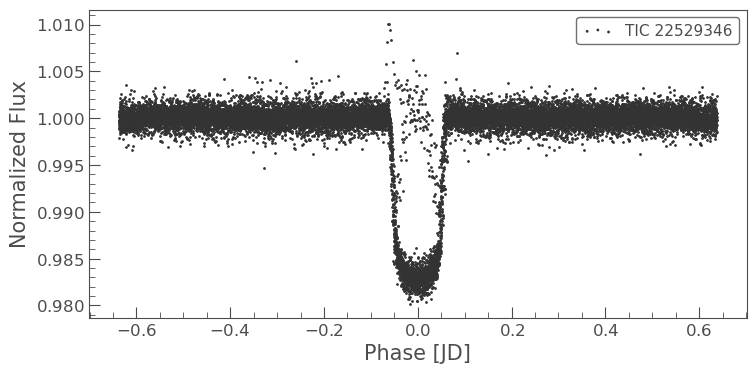

In [112]:
##Use our best-guess parameters from above
folded_data = lc.fold(period=best_period, epoch_time=best_epoch)
folded_data.scatter()
plt.show()
##Looks great! 

### Isolating the Secondary Eclipse
To determine the dayside temperature of WASP-121 b, we need to mask the primary eclipse over the range of time values. This is done easily by using our epoch and period measurements.

/home/nwhitsett/miniconda3/envs/exocore/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 15759 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/nwhitsett/miniconda3/envs/exocore/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/nwhitsett/miniconda3/envs/exocore/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 5334 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


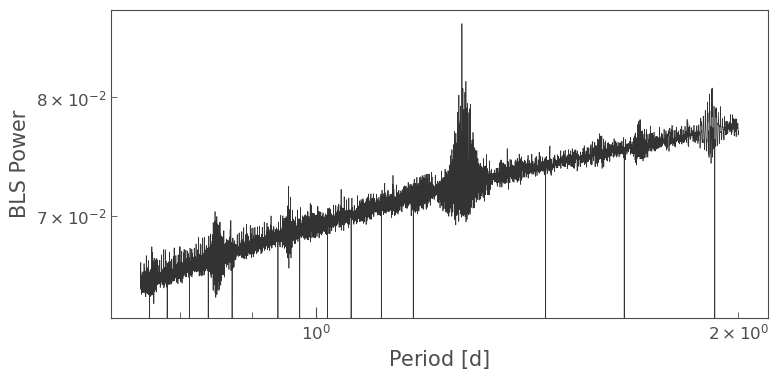

The best period is: 1.2706274475950157 d
The best depth is: 0.007671130299175606
The transit epoch is: 1491.939524238323
The duration is: 0.05 d


In [192]:
## To create the mask, we use the .create_transit_mask method.
## We pass our best guess period, epoch, and duration values.
## To be extra sure all of the primary transit is masked, we add an extra 0.1 days to the duration argument
mask = lc.create_transit_mask(period=float(best_period.value), transit_time = float(best_epoch.value), duration =float(best_duration.value)+0.1)

## Create a new time array with our mask using numpy's masked_array constructor
masked_time = np.ma.masked_array(lc.time.value, mask=mask)

## Create a new LightCurve object with our previous flux values, along with our new masked time array.
## We also need to specify that the LightCurve object is masked.
masked_lc = lk.LightCurve(flux=lc.flux, time=ap.time.Time(masked_time, format="jd", scale="utc"), masked = True)


## Now, rinse and repeat all of the methods we used for the BLS model for the secondary eclipse!
periodogram = masked_lc.to_periodogram(method = "bls", minimum_period = 0.75, maximum_period = 2, frequency_factor=7000)

periodogram.plot(view='period', scale='log')
plt.show()
best_period = periodogram.period_at_max_power
best_depth = periodogram.depth_at_max_power
best_epoch = periodogram.transit_time_at_max_power
best_duration = periodogram.duration_at_max_power
print("The best period is: " + str(best_period))
print("The best depth is: " + str(best_depth))
print("The transit epoch is: " + str(best_epoch))
print("The duration is: " + str(best_duration))

### Determine Tylos's Radius

To determine the radius and dayside temperature of Tylos, we need to know the radius and temperature of its host, WASP-121. From the NASA Exoplanet Archive, we see that WASP 121 has $T_{eff} = 6628 \pm 66 \, \mathrm{K}$ and $R_{\star} = 1.461±0.015 \, R_{\odot}$. The depth of an exoplanet transit is determined by:

$$Depth = \left(\frac{R_{\mathrm{planet}}}{R_{\star}}\right)^{2}$$

Thus, using our depth derived from above (0.0154), we can estimate that the radius of Tylos is:

$$\sqrt{0.0154}*(1.461\,R_{\odot}) \approx 0.1813 \, R_{\odot}\approx 1.764 \, R_{\mathrm{J}}$$

The radius value determined by [Bourrier et. al 2019](https://www.aanda.org/articles/aa/abs/2020/03/aa36640-19/aa36640-19.html) is $1.753\pm 0.036 \, R_{J}$, which puts the result in great agreement!

### Determine Tylos's Dayside and Equilibrium Temperatures

To derive the dayside temperature of Tylos, we need to evoke the Stefan-Boltzmann law, which can describe the luminosity $L$ of a blackbody emitting at a temperature $T$ with surface area $A$:

$$ L = A\sigma T^{4}$$

Treating Tylos as a blackbody and assuming that WASP-121 and Tylos are appoximately at the same distance from Earth during the secondary ecipse, the depth of the secondary eclipse is the **fractional luminsoty decrease due to Tylos being out of sight**. Thus:

$$Secondary\, Depth = \frac{L_{\mathrm{Dayside,Tylos}}}{L_{\mathrm{WASP-121}}} = \frac{4\pi(R_{\mathrm{Tylos}})^{2}(T_{\mathrm{Tylos}})^{4}}{4\pi(R_{\mathrm{WASP-121}})^{2}(T_{\mathrm{WASP-121}})^{4}}$$

Substituting in values:
$$0.00767 = \frac{(0.1813\,R_{\odot})^{2}(T_{\mathrm{Dayside,Tylos}})^{4}}{(1.461\,R_{\odot})^{2}(6,628\,\mathrm{K})^{4}}\rightarrow T_{\mathrm{Dayside, Tylos}} =5568\, \mathrm{K} $$

This seems very large! Remembering, however, that only one side of the planet is being irradiated at any given time, we can assume thermal equilibrium on either side, and assuming the irradiation of the host is the only source of thermal heating, we can average the temperature across both the day-time and night-time sides, leaving us with:
$$T_{\mathrm{Equi,Tylos}} = 5568 \, \mathrm{K} /2\approx 2784\, \mathrm{K}$$

[Mikal-Evans et al. 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.488.2222M/abstract) reports a value of $T_{\mathrm{Equi, Tylos}}2720\pm 8 \, \mathrm{K}$. Not bad!

### Note on Uncertainties
All the parameters derived in this solution have associated uncertainties. `LightKurve` wraps the BLS periodogram function from `astropy.timeseries.bls`. These uncertainties can be retrieved using the `periodogram.compute_stats` method.